# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

**Цель проекта** - построить модель для предсказания количества такси на следующий час.


Заранее установлен критерий качества модели:

- Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Для исследования предоставлена таблица `taxis.csv` с количеством заказов относительно времени.

Этапы исследования:
1. Обзор данных
2. Предобработка данных
3. Разведочный анализ данных
4. Подбор модели и прогнозирование
5. Интерпретация результатов и выводы

## 1. Обзор данных 

Импортируем библиотеки, скачаем данные и посмотрим их и оценим соответствуют ли они задаче. 

In [34]:

! pip install -U scikit-learn -q


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [35]:
import os
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder , StandardScaler, OrdinalEncoder
from sklearn.metrics import root_mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, cross_val_score
import lightgbm as lgb

from datetime import date

RANDOM_STATE = 42
sns.set_palette("pastel")

In [36]:
if os.path.exists('../Downloads/taxi.csv'):
    taxi = pd.read_csv('../Downloads/taxi.csv')
elif os.path.exists('/datasets/taxi.csv'):
    taxi = pd.read_csv('/datasets/taxi.csv')
else:
    print('Something is wrong')

In [37]:
taxi.sample(10)

,datetime,num_orders
17661,2018-07-01 15:30:00,12
24060,2018-08-15 02:00:00,17
1835,2018-03-13 17:50:00,1
11112,2018-05-17 04:00:00,19
18478,2018-07-07 07:40:00,10
8206,2018-04-26 23:40:00,24
2256,2018-03-16 16:00:00,11
9022,2018-05-02 15:40:00,9
10946,2018-05-16 00:20:00,7
8259,2018-04-27 08:30:00,7


In [38]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [39]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


### Вывод
- Таблица состоит из двух столбцов - временная метка и количество заказов такси в это время. 
- В таблице 26496 записей.
- Данные соответсвуют описанию задачи

## 2. Предобработка данных

- изменим тип временной отметки на datetime, чтобы продолжить с ней работать в соответсвующем ключе.

In [40]:
print(taxi.duplicated().sum())
print(taxi.isna().sum())

0
datetime      0
num_orders    0
dtype: int64


In [41]:
taxi.datetime = pd.to_datetime(taxi.datetime)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


In [42]:
taxi.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [43]:
taxi.tail()

,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


Сделаем временную отметку индексом временного ряда. 

In [44]:
taxi.set_index('datetime', inplace=True)
taxi.sample()

,num_orders
datetime,
2018-05-03 07:20:00,0


Посмотрим упорядочен ли ряд.

In [45]:
print(taxi.index.is_monotonic_decreasing)
print(taxi.index.is_monotonic_increasing)

False
True


<Axes: title={'center': 'Изменение количества поездок со временем'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

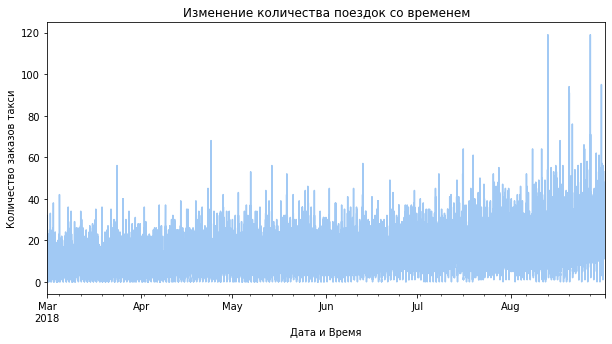

In [46]:
taxi.plot(title='Изменение количества поездок со временем',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))

In [47]:
taxi[taxi.num_orders>70].count()

num_orders    19
dtype: int64

Ряд монотонно возрастает, временные отметки упорядочены.

- Сделаем ресемплирование по одному часу, т.к. нас интересует количество заказов в час.

<Axes: title={'center': 'Изменение количества поездок по часам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

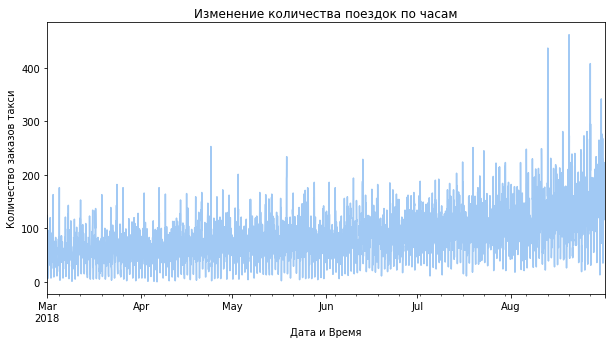

In [48]:
taxi = taxi.resample('1H').sum()
taxi.plot(title='Изменение количества поездок по часам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))

### Вывод по предобработке
- в данных нет пропусков и дубликатов
- изменили тип данных временной отметки на datetime
- ряд монотонно возрастает, временные отметки упорядочены.
- сделали ресемплирование временного ряда по одному часу (в каждой группе считали сумму значений)


## 3. Разведочный анализ временного ряда

- оценим тренд и сезонность изменения количество заказов такси

<Axes: title={'center': 'Изменение количества поездок - среднее по суткам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

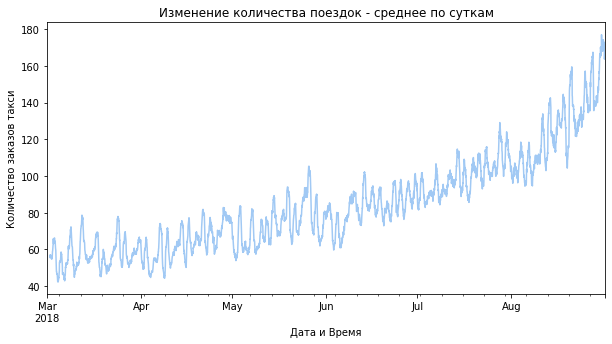

In [49]:
taxi.rolling(24).mean().plot(title='Изменение количества поездок - среднее по суткам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    legend=False,
    figsize=(10,5))


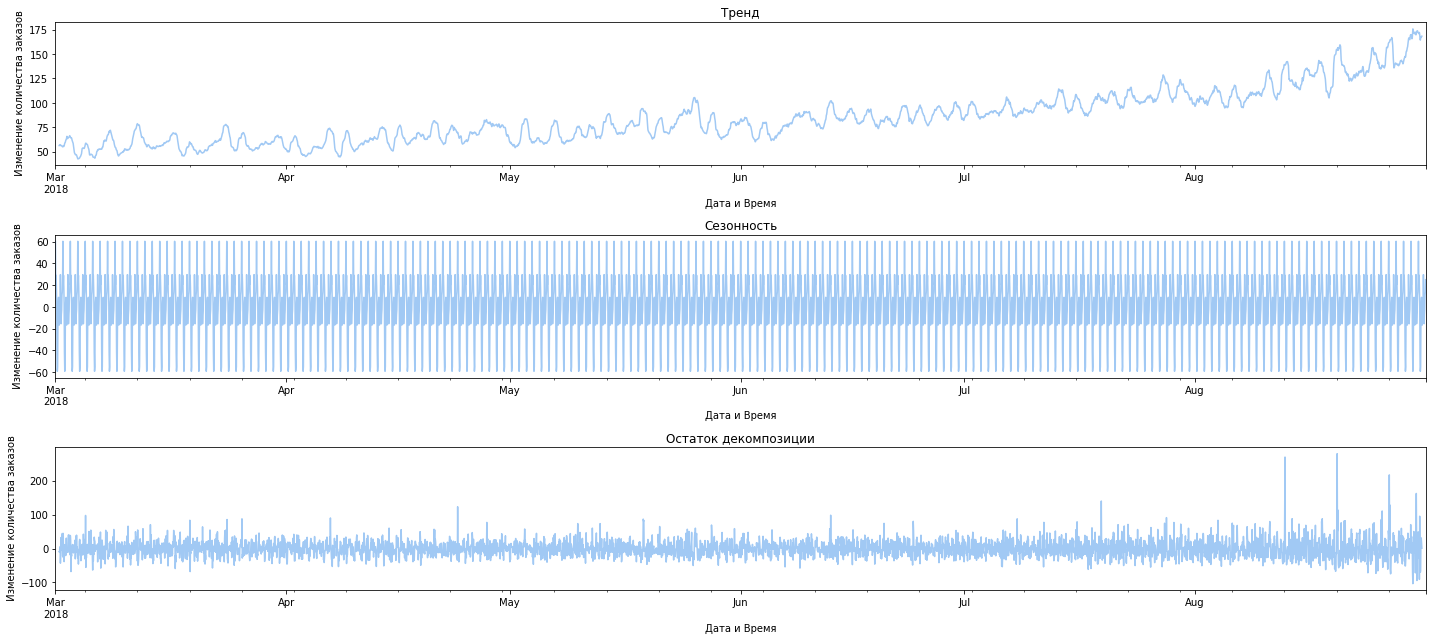

In [50]:
decomposed = sm.tsa.seasonal_decompose(taxi)

plt.figure(figsize=(20, 9))
plt.subplot(311) 
decomposed.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Остаток декомпозиции')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.tight_layout()

- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночтю ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.

<Axes: title={'center': 'Закономерности изменения числа заказов 1-2 марта 2018'}, xlabel='Дата и Время', ylabel='Количество заказов такси '>

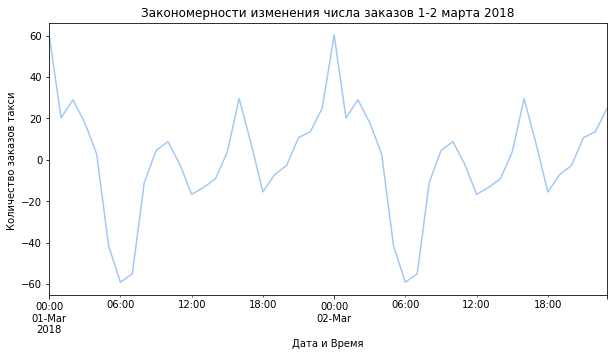

In [51]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(title='Закономерности изменения числа заказов 1-2 марта 2018',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси ',
    legend=False,
    figsize=(10,5))


### Вывод по анализу
- Представлены данные с марта по август 2018 года. 
- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночтю ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.

## 4. Обучение модели и предсказание

Нам необходимо решить задачу регрессии.

Цель по качеству модели - Значение метрики RMSE на тестовой выборке должно быть не больше 48.

Таргет - количества заказов такси в аэропорте за час.

### 4.1 Подготовка данных

В качестве входных признаков (их надо добавить) будем использовать день недели, месяц, день месяца, исторические данные (отстающие значения) и скользящее среднее.



Составим собственную функцию, которая добавляет признаки, на случай если будем их менять (количество периодов исторических данных, размер окна для скользящего среднего):

In [52]:
def make_features(data, max_lag, rolling_mean_size):
    data_new_feat = data.copy()
    data_new_feat['dayofweek'] = data_new_feat.index.dayofweek
    data_new_feat['day'] = data_new_feat.index.day
    data_new_feat['month'] = data_new_feat.index.month
    for i in range(1, max_lag+1):
        data_new_feat[f'lag_{i}'] = data_new_feat['num_orders'].shift(i)
    
    data_new_feat['rolling_mean'] = data_new_feat['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    return data_new_feat



In [135]:
taxi_ml = make_features(taxi, 24, 12)

In [136]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [137]:
taxi_ml.head()

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Подготовим данные и посмотрим на базовую линейную регрессию:

In [138]:
train, test = train_test_split(taxi_ml, shuffle=False, test_size=0.1)
train = train.dropna()

train_target = train['num_orders']
train_features = train.drop(['num_orders'], axis=1)

test_target = test['num_orders']
test_features = test.drop(['num_orders'], axis=1)

print(train.shape)
print(test.shape)


(3950, 29)
(442, 29)


In [139]:
num_columns = train_features.columns
num_columns

Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object')

In [140]:
data_preprocessor = ColumnTransformer(
    [
        ('num', StandardScaler(), num_columns),
    ], 
    remainder='passthrough'
)

In [141]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models',  LinearRegression())
    ]
)

### 4.2 Подбор модели

In [142]:
pipe_final.fit(train_features,train_target)
cv_score = round(abs(cross_val_score(pipe_final,  train_features, train_target, cv=TimeSeriesSplit(5), scoring='neg_root_mean_squared_error').mean()),2)

print("RMSE при кроссвалидации:", cv_score)

RMSE при кроссвалидации: 4531970944374.61


Базовая линейная регрессия дает результат с очень большой ошибкой.

Рассмотрим другие варианты моделей с разными гиперпараметрами.

In [143]:
param_distributions = [
    
        {'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 10),
        'models__min_samples_split': range(2, 10)} ,

        {'models': [lgb.LGBMRegressor(random_state=RANDOM_STATE)],
        'models__learning_rate': np.arange(0.1, 0.6, 0.1),
        'models__max_depth': range(2,4),
        'models__n_estimators': range(50,100, 10) },

        {'models': [ElasticNet(random_state=RANDOM_STATE)],
         'models__alpha':np.arange(0.1, 2, 0.4)} ,
]


In [144]:
randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_distributions=param_distributions, 
    scoring='neg_root_mean_squared_error', 
    random_state=RANDOM_STATE,
    cv=TimeSeriesSplit(5),
    n_jobs=-1
)
randomized_search.fit(train_features, train_target) 

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000838 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4852
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 28
[LightGBM] [Info] Start training from score 78.421013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               StandardScaler(),
                                                                               Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_...
                                         'models__min_samples_split': range(2, 10)},
                                        {'models': [LGBMRegressor(random_state=42)],
                                         'models__learning_rate': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                         'models__max_depth': range(2, 4),
                                         'models__n_estimators': range(50, 100, 10)},
                                        {'models': [ElasticNet(random_state=42)],
                                         'models__alpha': array([0.1, 0.5, 0.9, 1.3, 1.7])}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [145]:
print('Метрика RMSE для лучшей модели:\n', round(abs(randomized_search.best_score_),2))
print('\nЛучшая модель и её параметры:\n\n', randomized_search.best_estimator_) 

Метрика RMSE для лучшей модели:
 25.91

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num', StandardScaler(),
                                                  Index(['dayofweek', 'day', 'month', 'lag_1', 'lag_2', 'lag_3', 'lag_4',
       'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11',
       'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18',
       'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24',
       'rolling_mean'],
      dtype='object'))])),
                ('models',
                 LGBMRegressor(max_depth=3, n_estimators=90, random_state=42))])


Лучшая модель после RandomizedSearchCV - это LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1) имеет RMSE 25.91. Ошибка намного меньше чем после линейной регрессии и подходит под критерий качества.

Выбираем лучшей моделью - LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1).

In [146]:
f'Значение RMSE на тестовой выборке  для линейной регрессии: {round(root_mean_squared_error(test_target, randomized_search.best_estimator_.predict(test_features)),2)}'

'Значение RMSE на тестовой выборке  для линейной регрессии: 42.85'

Качество модели на тестовой выборке отвечает критерию качества (RMSE<48).

### 4.3 Проверка адекватности модели
- посмотрим RMSE, если сделаем прогноз константой (медианой)

In [147]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_median =  np.ones(test.shape[0]) * train['num_orders'].median()

print("RMSE:", root_mean_squared_error(test['num_orders'], pred_median))

Среднее количество заказов в час: 139.55656108597285
RMSE: 87.15277582981295


- прогноз предыдущим значением ряда

In [148]:
print("Среднее количество заказов в час:", test['num_orders'].mean())

pred_previous = test['num_orders'].shift(fill_value = train['num_orders'].iloc[-1])
print("RMSE:", root_mean_squared_error(test['num_orders'],pred_previous ))

Среднее количество заказов в час: 139.55656108597285
RMSE: 58.856486242815066


Получается, что наша модель не бесполезна и с помощью нее мы можем строить более точные прогнозы.

In [149]:
y_pred = pipe_final.predict(test_features)
test['pred_num_orders'] = y_pred
test.sample(4)

,num_orders,dayofweek,day,month,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean,pred_num_orders
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-15 04:00:00,137,2,15,8,102.0,157.0,98.0,211.0,212.0,81.0,...,162.0,155.0,135.0,91.0,54.0,45.0,47.0,139.0,127.833333,114.997906
2018-08-28 23:00:00,179,1,28,8,160.0,189.0,94.0,111.0,113.0,211.0,...,65.0,55.0,106.0,157.0,133.0,133.0,192.0,157.0,144.083333,153.529156
2018-08-21 15:00:00,125,1,21,8,121.0,68.0,108.0,140.0,141.0,113.0,...,170.0,153.0,77.0,152.0,122.0,111.0,172.0,223.0,114.500000,155.841656
2018-08-29 15:00:00,163,2,29,8,196.0,135.0,167.0,179.0,183.0,143.0,...,160.0,189.0,94.0,111.0,113.0,211.0,148.0,184.0,131.583333,172.310406


<Axes: title={'center': 'Изменение количества поездок по часам'}, xlabel='Дата и Время', ylabel='Количество заказов такси'>

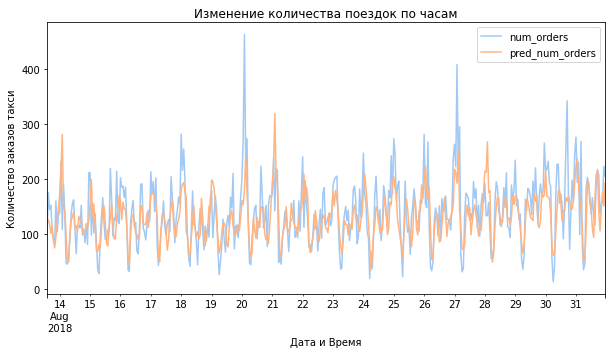

In [150]:
test[['num_orders', 'pred_num_orders' ]].plot(title='Изменение количества поездок по часам',
    xlabel='Дата и Время',
    ylabel='Количество заказов такси',
    figsize=(10,5))

На графике видно, что предсказания в целом хорошо соотвествуют реальным значениям таргета.

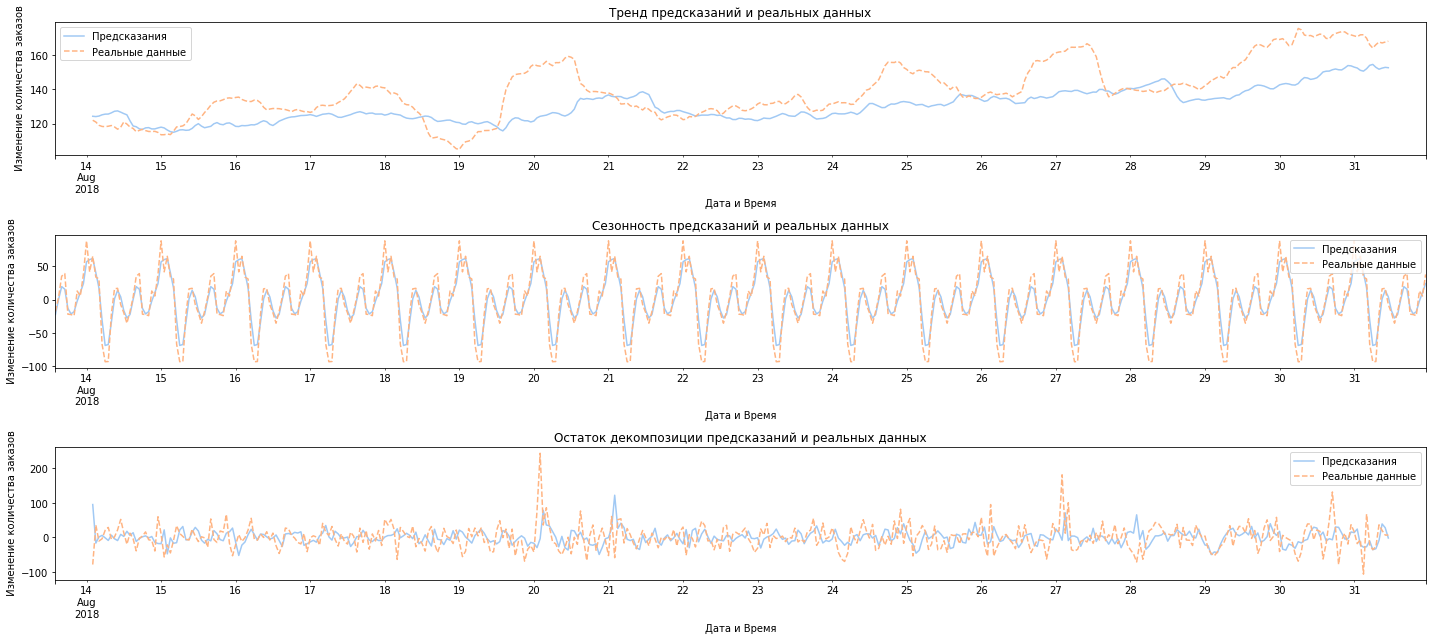

In [151]:
decomposed_pred = sm.tsa.seasonal_decompose(test['pred_num_orders'])

decomposed_actual = sm.tsa.seasonal_decompose(test['num_orders'])

plt.figure(figsize=(20, 9))


ax1 = plt.subplot(311)
decomposed_pred.trend.plot(ax=ax1, label='Предсказания')
decomposed_actual.trend.plot(ax=ax1, label='Реальные данные', linestyle='--')
plt.title('Тренд предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()


ax2 = plt.subplot(312)
decomposed_pred.seasonal.plot(ax=ax2, label='Предсказания')
decomposed_actual.seasonal.plot(ax=ax2, label='Реальные данные', linestyle='--')
plt.title('Сезонность предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()


ax3 = plt.subplot(313)
decomposed_pred.resid.plot(ax=ax3, label='Предсказания')
decomposed_actual.resid.plot(ax=ax3, label='Реальные данные', linestyle='--')
plt.title('Остаток декомпозиции предсказаний и реальных данных')
plt.xlabel('Дата и Время')
plt.ylabel(' Изменение количества заказов')
plt.legend()


plt.tight_layout()

Тренд и сезонность предсказаний очень похожи на изменение реальных значений признака.

### Вывод
- Для обучения модели и получения предсказаний добавили новые признаки:день недели, месяц, день месяца, исторические данные (отстающие значения) за предыдущие сутки и скользящее среднее по 12 значеним (не включая текущее).
- Данные стандартизовали с помощью StandardScaler и обучили модели линейной регрессии, дерева решений и модели на основе градиентного бустинга LightGBM.
- Лучшее качество при кроссвалидации было получено для бустинга LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1). RMSE = 25.91.
- Для этой модели оценили качество на тестовой выборке. RMSE = 42.85. Это значение соотвествует критерию качества RMSE<48.
- Проверили адеквантна ли модель: значения ошибки RMSE равны 87.15 и 58.85 для прозноза медианой тренировочной выборки и прогноза предыдущим значеним ряда.
- По графикам определили, что предсказания в целом хорошо соотвествуют реальным значениям таргета.



## 5. Итоговый вывод исследования

1. Обзор данных
- Таблица `taxi.csv` состоит из двух столбцов - временная метка и количество заказов такси в это время. 
- В таблице 26496 записей.
- Данные соответсвуют описанию задачи.
2. Предобработка данных
- В данных нет пропусков и дубликатов
- Изменили тип данных временной отметки на `datetime`
- Ряд монотонно возрастает, временные метки упорядочены.
- Сделали ресемплирование временного ряда по одному часу (в каждой группе посчитали суммарное число заказов за час)
3. EDA
- Представлены данные с марта по август 2018 года. 
- Имеется тренд к росту числа заказов такси из аэропорта с марта по август 2018 года.
- Имеются повторяющиеся закономерности в масштабе суток: пик заказов наблюдается ночью - точнее в полночь, минимальное число заказов такси из аэропорта - рано утром , около 6 утра. Эта закономерность может быть связана, например, с режимом работы общественного транспорта (ночтю ходит реже или вообще не ходит) или предпочтениями пассажиров к времени прилета при выборе рейсов.
4. Обучение модели и предсказание
- Для обучения модели и получения предсказаний добавили новые признаки:день недели, месяц, день месяца, исторические данные (отстающие значения) за предыдущие сутки и скользящее среднее по 12 значеним (не включая текущее).
- Данные стандартизовали с помощью StandardScaler и обучили модели линейной регрессии, дерева решений и модели на основе градиентного бустинга LightGBM.
- Лучшее качество при кроссвалидации было получено для бустинга LGBMRegressor(max_depth=3, n_estimators=90,learning_rate = 0.1). RMSE = 25.91.
- Для этой модели оценили качество на тестовой выборке. RMSE = 42.85. Это значение соотвествует критерию качества RMSE<48.
- Проверили адеквантна ли модель: значения ошибки RMSE равны 87.15 и 58.85 для прозноза медианой тренировочной выборки и прогноза предыдущим значеним ряда.
- По графикам определили, что предсказания в целом хорошо соотвествуют реальным значениям таргета.

Таким образом, согласно критерию по качеству, выбираем лучшей моделью для данной задачи **модель на основе градиентного бустинга LightGBM с глубиной дерева 3, 90 моделями в ансамбле и скоростью обучения 0.1**. Ее качество на тестовой выборке RMSE = 42.85.
